# Grade: /100 pts

# Assignment 06: Regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

%matplotlib inline

### Question 1: Preprocessing (5 pts)
**Make sure to only use the imports included in the first cell. Any additional imports used will result in 0.** <br>
Tasks:
* Load the data present in 'footballer_small.csv' using the pandas library and store the loaded data in a dataframe
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0 <br>

In [2]:
df = pd.read_csv('footballer_small.csv')

# Drop the columns
df = df.drop(columns = ['ID', 'club', 'club_logo', 'birth_date', 'flag', 'nationality', 'photo', 'potential'])

df['work_rate_att'] = pd.Categorical(df.work_rate_att)
df['work_rate_def'] = pd.Categorical(df.work_rate_def)
df['preferred_foot'] = pd.Categorical(df.preferred_foot)

df = pd.get_dummies(df, prefix = ['work_rate_att', 'work_rate_def', 'preferred_foot'], columns = ['work_rate_att', 'work_rate_def', 'preferred_foot'])

X = df.drop('overall', axis = 'columns')

y = df['overall']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 500, random_state = 0)

## Question 2: Building the pipeline that preprocesses the data (10 pts)
In order to properly build the regression model, the features need to be standardized so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build the pipeline that preprocesses the feature columns of the training data and create a linear regression model. Plot the data before and after the standardization for the stamina feature. <br>
In this question, there is no need to overwrite the training set's values. Create a new variable to include the standardized data. The original training data is needed for future exercises. <br>
### Question
We can observe that the standardized data for stamina has a mean of 0, and follows a normal distribution, while the non-standardized data doesn't have a normal distribution, and a mean of around 70.

In [3]:
model = sk.linear_model.LinearRegression()

# Developing the pipeline
pipeline = Pipeline([('scaling', StandardScaler()),
                                      ('linreg', model)])

scaler = StandardScaler(with_mean = True, with_std=True)
X_std = scaler.fit_transform(Xtrain)
X_std_df = pd.DataFrame(X_std, columns = Xtrain.columns)

# Fitting the model
model.fit(X_std_df, ytrain)

LinearRegression()

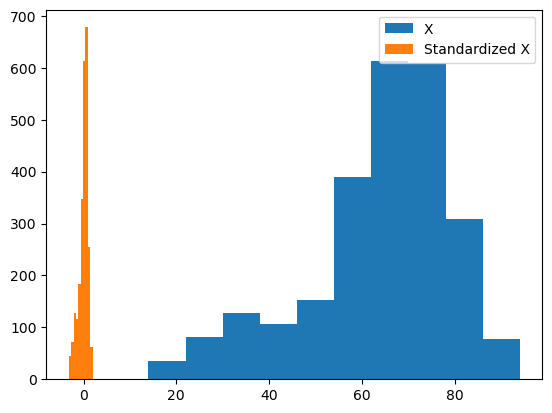

In [4]:
# Visualizing the data
plt.hist(Xtrain.stamina, label = 'X')
plt.hist(X_std_df.stamina, label = 'Standardized X')
plt.legend()
plt.show() 

## Question 3: Creating a Complex feature model using 2-nd Polynomial features (10 pts)
In this task, the training data consists of the quadratic terms and 2-way interactions of all features except one of standing_tackle, composure, and marking variable. <br> 
Create <b> four </b> different training sets:
* The first training set includes the quadratic terms and 2-way interactions of all the features. 
* The second/third/fourth training sets include all the features, their quadratic terms, and their 2-way interactions except the standing_tackle/composure/marking features. <br>

#### Hint: 
For the 2nd/3rd and 4th training sets, create the training sets without the aforementioned features and then apply polynomial expansion to the resultant sets. 
### Questions:
* How many linear terms are in each of the new feature set? <br>
There are 48 linear terms in the first dataset, and 47 linear terms in models 2-4.
* How many squared terms are in each of the new feature set? <br>
There are 48 squared terms in the first dataset, and 47 squared terms in models 2-4
* How many interaction terms are in each of the new feature set? Give an example of one of the interaction terms.<br>
There are 1130 interaction terms. One of these interaction terms is $\beta x_{standing_tackle} x_{composure}$

In [5]:
poly = sk.preprocessing.PolynomialFeatures(degree = 2)

# All features
x_poly_all = poly.fit_transform(Xtrain)

In [6]:
# Excluding standing_tackle
Xtrain_poly_tackle = Xtrain.drop('standing_tackle', axis = 'columns').values
x_poly_tackle = poly.fit_transform(Xtrain_poly_tackle)

# Excluding composure
Xtrain_poly_composure = Xtrain.drop('composure', axis = 'columns').values
x_poly_composure = poly.fit_transform(Xtrain_poly_composure)

# Excluding marking variable
Xtrain_poly_mark = Xtrain.drop('marking', axis = 'columns').values
x_poly_mark = poly.fit_transform(Xtrain_poly_mark)

## Question 4: Evaluating the backward feature search (15 pts)
In this question, you have to use the pipeline created in question 2 and apply it to each of the training sets created in question 3. Use 10-fold cross validation to report the validation error on the training set using mean squared error as the metric. <br>
Show all the steps of the process and compare and analyze the results using the validation error reported. 

In [15]:
train_set = [x_poly_all, x_poly_tackle, x_poly_composure, x_poly_mark]

for set in train_set:
    cv_scores = cross_val_score(pipeline, set, ytrain, cv = 10, scoring = 'neg_mean_squared_error')
    print(f"CV loss: {-cv_scores.mean()}")

CV loss: 2.974918936860572
CV loss: 2.753691907706685
CV loss: 2.8095979493446817
CV loss: 2.7019949592912123


## Question 5: Applying Ridge Regression (10 pts)
Build a pipeline that performs scaling and fits the ridge regression on the data that includes the polynomial expansion of all the features. The penalization parameter is set to 0.5. Use the pipeline to report the validation error using mean square error metric. Use 10-fold cross validation. 

In [16]:
RidgeModel = Pipeline([('scaling', StandardScaler()),
                               ('ridge_reg', Ridge(alpha = 0.5))])

cv_scores = cross_val_score(RidgeModel, x_poly_all, ytrain, cv = 10, scoring = 'neg_mean_squared_error')
print(f"CV loss: {-cv_scores.mean()}")

CV loss: 1.7146770020416877


## Question 6: Tune the Ridge coefficient for the 2nd-order model   (15 pts)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search going from $\lambda = \exp(-8), \cdots, \exp(6)$ in 15 evenly spaced increments on the log scale. Plot the mean squared error as a function of $\log(\lambda)$. 

### Questions: 

What is the best regularization parameter (actual not approximate)? <br>
The best regularization parameter is exp(6), as this produces the lowest MSE.

Why does the error increase as $\lambda \rightarrow 0?$  Why does the error increase when $\lambda \rightarrow \infty$? Answer in terms of the bias variance trade off. <br>
As $\lambda \rightarrow 0?$, the error increases, as there is no longer a penalty onto the coefficients, thus making it equivalent to a linear regression. While this minimizes trianing error, it increases in variance. On the contrast, as $\lambda \rightarrow \infty$, it creates too large of a penalty, forcing the coefficients to approach zero, which causes underfitting. Thus, as variance decreases, the bias increases.

/Users/yunkyaw/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.70233e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/yunkyaw/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.77326e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/yunkyaw/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.72397e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/yunkyaw/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.76073e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/yunkyaw/opt/anaconda3

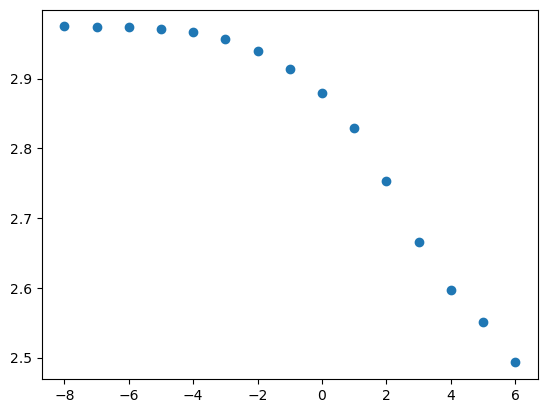

In [9]:
lam = np.exp(np.linspace(-8,6,15))

mse = np.zeros(15)

for i in range(lam.size):
    
    cv_scores = cross_val_score(Ridge(alpha = lam[i]), x_poly_all, ytrain, cv = 10, scoring='neg_mean_squared_error')

    mse[i] = -cv_scores.mean() 

plt.scatter(np.log(lam), mse)
plt.show()

### Question 7: Test error  (10 pts)
Now test how the ridge model, fitted to the whole training set, performs on the test data set. 


Report the following:

* The mean squared error on the test data - along with the 95% confidence interval, determined with the central limit theorem. 
* The proportion of the variance explained by your model - along wth a 95% confidence interval.

In [10]:
ridge = Ridge(alpha = np.exp(6), fit_intercept = True)

ridge.fit(x_poly_all, ytrain)

x_test_poly = poly.fit_transform(Xtest.values)

ypred = ridge.predict(x_test_poly)

mse = mean_squared_error(ytest, ypred)

abs_error = np.abs(ytest - ypred)

confidence_int = (np.quantile(abs_error, 0.025), np.quantile(abs_error, 0.975))

print('My confidence interval is between', confidence_int[0], 'and', confidence_int[1])

r2 = sk.metrics.r2_score(ytest, ypred)

print('My R2 is', r2)

My confidence interval is between 0.021458431352540688 and 3.901230939256674
My R2 is 0.949922116426236


## Question 8: Analyzing Ridge Coefficients (15 pts)
In this question, you are first required to extract all the coefficients of the standing tackle, composure and marking features from the best model of question 7. After that, calculate the mean of the coefficients of the aforementioned features and analyze the results. Based on these observations, draw conclusions about the results in question 4. 

Here, we find the mean of the coefficients is roughly 0.01269, this suggests that these coefficients do not significantly impact the model. Considering we find a lower cv in models 2-4 (in question 4), this concurs with this, as it suggests that removing these coefficients is more beneficial to the model.

In [17]:
feat_names = poly.get_feature_names_out(Xtrain.columns)
feat_coef = ridge.coef_

coef_df = pd.DataFrame({'Feature': feat_names, 'Coefficient': feat_coef})

select_feat = ["standing_tackle", "composure", "marking"]

select_coef = coef_df[coef_df['Feature'].isin(select_feat)]['Coefficient']
print(select_coef)

mean_coef = select_coef.mean()

print(mean_coef)

38    0.007789
39    0.011361
40    0.018923
Name: Coefficient, dtype: float64
0.012690936419613311


## Question 9: Lasso Regression (10 pts)
Let us assume that you are building a linear regression model using only three features: standing tackle, marking, and composure to predict a player's overall rating. Based on the results of question 8, what do you think will be the features' coefficients while applying the lasso regression optimization? Answer in no more than 5 sentences.

Upon applying the lasso regression, we would expect to find that the feature's coefficients are relatively small, with standing_tackle having the lowest coefficient, and marking having the largest.

In [12]:
Xlas_train = Xtrain[["standing_tackle", "composure", "marking"]]
Xlas_test = Xtest[["standing_tackle", "composure", "marking"]]

las = sk.linear_model.Lasso(alpha = 0.05, fit_intercept = True)
las.fit(Xlas_train, ytrain)

las.coef_

array([-0.0484303 ,  0.3589039 ,  0.03904743])

## Note: 
After completing all the tasks and before submitting: 
* Restart you kernel by clicking 'Restart & Run all'
* Fix any errors resulting from the first step.
* Repeat the first two steps until no errors are encountered. 